#Using the Fast Gradient Sign Attack to fool a classifier

In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import numpy as np

In [0]:
%matplotlib inline

In [0]:
torch.cuda.is_available()

True

In [0]:
fashion_mnist_link = r"https://github.com/zalandoresearch/fashion-mnist/archive/"
import requests
import zipfile
from pathlib import Path

filename = "master.zip"
path = Path(".")
data_path = path / "data"

if not (path / filename).exists():
    data = requests.get(fashion_mnist_link + filename).content
    (path / filename).open("wb").write(data)

with zipfile.ZipFile(path / filename, "r") as _:
    _.extractall(data_path)

In [0]:
!mv data/fashion-mnist-master/* data/
!ls data

app.py		 doc		       README.ja.md	 utils
benchmark	 Dockerfile	       README.md	 visualization
configs.py	 fashion-mnist-master  README.zh-CN.md
CONTRIBUTING.md  LICENSE	       requirements.txt
data		 MAINTAINERS	       static


In [0]:
import data.utils.mnist_reader as mnist_reader

In [0]:
x_train, y_train = mnist_reader.load_mnist(data_path / 'data/fashion', kind='train')
x_test, y_test = mnist_reader.load_mnist(data_path / 'data/fashion', kind='t10k')

In [0]:
x_train, x_test = map(
    lambda a: torch.tensor(a),
    (x_train, x_test)
)
 
y_train, y_test = map(
    lambda a:torch.tensor(a, dtype=torch.long),
    (y_train, y_test)
)

#because CNNs require dimensions (N, C, W, H)
#so inserting a singleton dimension since we have grayscale images
x_train = x_train.reshape(-1, 28, 28).float().unsqueeze(1)
x_test = x_test.reshape(-1, 28, 28).float().unsqueeze(1)
y_train.dtype

torch.int64

In [0]:
print(x_train.shape, y_train.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000])


In [0]:
from itertools import count

def images_show(images, w, h, colormap="gray"):
    for image, c in zip(images, count()):
        plt.subplot(w, h, c+1)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(image[0], cmap=colormap)
    
    plt.show()

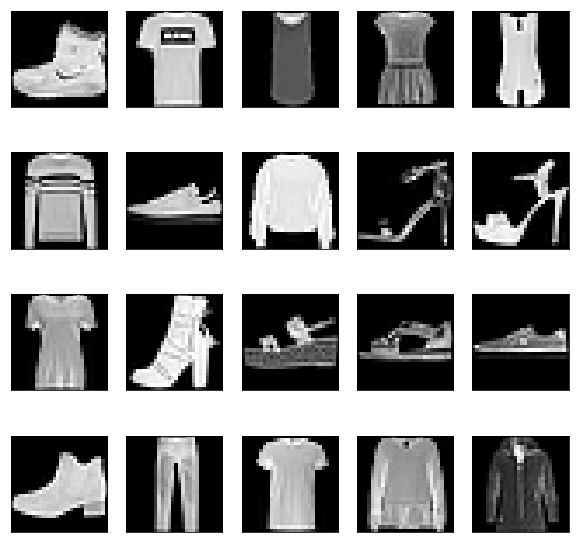

In [0]:
plt.rcParams["figure.figsize"] = [10, 10]
images_show(x_train[:20], 4, 5)

In [0]:
def train(model, x_train, y_train, num_epochs, optimizer, bs):
    #not even random sampling, just taking labelled examples in a sequence of batches
    for epoch in range(num_epochs):
        for i in range((x_train.shape[0] // bs)):
            start_i = i * bs
            end_i = start_i + bs
            optimizer.zero_grad()
            
            xb = x_train[start_i:end_i].to("cuda")
            yb = y_train[start_i:end_i].to("cuda")
            
            try:
                preds = model(xb)
            except:
                print(xb.shape, yb.shape)
                return
                
            loss = F.nll_loss(preds, yb)
            loss.backward()
            optimizer.step()

            if (i + 1) % 50 == 0:
                print("Epoch {}: [{} / {}]\tbatch #{} loss {}".format(
                    epoch, end_i, x_train.shape[0], i, loss.item()
                ))
                
def test(model, x_test, y_test, bs):
    test_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        for i in range((x_test.shape[0] // bs)):
            start_i = i * bs
            end_i = start_i + bs
            
            xb = x_test[start_i:end_i].to("cuda")
            yb = y_test[start_i:end_i].to("cuda")
            
            preds = model(xb)
            test_loss += F.nll_loss(preds, yb)
            
            preds = preds.argmax(dim=1)
            correct += preds.eq(yb).sum().item()
    
    test_loss /= x_test.shape[0]
    
    print("Test average loss:{} accuracy:{}/{}".format(
        test_loss, correct, x_test.shape[0]
    ))

def test_confusion(model, x_test, y_test, classes, bs):
    confusion_matrix = torch.zeros(len(classes), len(classes), dtype=torch.int)
    
    with torch.no_grad():
        for i in range((x_test.shape[0] // bs)):
            start_i = i * bs
            end_i = start_i + bs
            
            xb = x_test[start_i:end_i].to("cuda")
            yb = y_test[start_i:end_i].to("cuda")
            
            preds = model(xb)
            
            preds = preds.argmax(dim=1)
            
            confusion_matrix[yb.item()][preds.item()] += 1
    
    return confusion_matrix

In [0]:
classes = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [0]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        #in_channels, out_channels, kernel_size, stride
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=4, stride=1)
        self.fc1 = nn.Linear(5*5*20, 32)
        self.fc2 = nn.Linear(32, 10)
        self.logging = False
    
    def forward(self, xb):
        if self.logging:
            print("\n\nforward start:")        
            print(xb.shape)
        x = F.relu(self.conv1(xb))
        if self.logging:
            print(x.shape)
        x = F.avg_pool2d(x, 2, 2)
        if self.logging:
            print(x.shape)
        x = F.relu(self.conv2(x))
        if self.logging:
            print(x.shape)
        x = F.avg_pool2d(x, 2, 2)
        if self.logging:
            print(x.shape)
        #image transformed to 5*5, out_channels of conv2 are 20
        x = x.view(-1, 5*5*20)
        if self.logging:
            print(x.shape)
        x = F.relu(self.fc1(x))
        if self.logging:
            print(x.shape)
        x = self.fc2(x)
        if self.logging:
            print(x.shape)
            print("forward end\n\n")
        return F.log_softmax(x, dim=1)
    
    def toggle_logging_(self):
        self.logging = !self.logging

model3 = Net3().to("cuda")
optimizer3 = optim.RMSprop(model3.parameters())

train(model3, x_train, y_train, 15, optimizer3, 100)

test(model3, x_test, y_test, 100)

Epoch 0: [5000 / 60000]	batch #49 loss 0.8379426002502441
Epoch 0: [10000 / 60000]	batch #99 loss 0.6856131553649902
Epoch 0: [15000 / 60000]	batch #149 loss 0.8884991407394409
Epoch 0: [20000 / 60000]	batch #199 loss 0.8719473481178284
Epoch 0: [25000 / 60000]	batch #249 loss 0.6143337488174438
Epoch 0: [30000 / 60000]	batch #299 loss 0.5885372161865234
Epoch 0: [35000 / 60000]	batch #349 loss 0.5896936655044556
Epoch 0: [40000 / 60000]	batch #399 loss 0.6890996694564819
Epoch 0: [45000 / 60000]	batch #449 loss 0.6239812970161438
Epoch 0: [50000 / 60000]	batch #499 loss 0.678301215171814
Epoch 0: [55000 / 60000]	batch #549 loss 0.598120927810669
Epoch 0: [60000 / 60000]	batch #599 loss 0.5059942007064819
Epoch 1: [5000 / 60000]	batch #49 loss 0.5939986705780029
Epoch 1: [10000 / 60000]	batch #99 loss 0.5777676105499268
Epoch 1: [15000 / 60000]	batch #149 loss 0.6876615881919861
Epoch 1: [20000 / 60000]	batch #199 loss 0.6624082922935486
Epoch 1: [25000 / 60000]	batch #249 loss 0.46480

Text(0, 0.5, 'true labels')

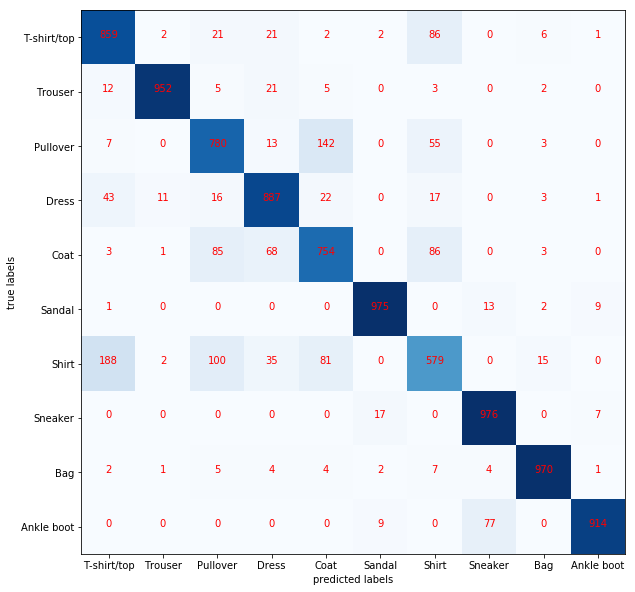

In [0]:
mat = test_confusion(model3, x_test, y_test, classes,  1)

plt.rcParams["figure.figsize"] = [10, 10]
plt.imshow(mat, cmap="Blues")
plt.xticks(np.arange(0, len(classes)), list(classes.values()))
plt.yticks(np.arange(0, len(classes)), list(classes.values()))

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        plt.text(j, i, "{}".format(mat[i][j]), horizontalalignment="center", color="red")

plt.xlabel("predicted labels")
plt.ylabel("true labels")

In [0]:
def fgsa_get_nabla_sign(model, x_single, y_single):
    data = x_single.clone().to("cuda")
    label = y_single.clone().to("cuda")
    data.requires_grad = True
    
    pred = model(data)
    loss = F.nll_loss(pred, label)
    
    loss.backward()
    
    data_grad = data.grad.data
    
    return data_grad.sign()

def rescale_tensor(t):
    """rescale values to be in [0, 1]"""
    a = t.clone()
    b = t.clone()
    for i in range(t.dim()):
        a = a.max(t.dim()-i-1).values
        b = b.min(t.dim()-i-1).values
    print("max: {}".format(a.item()))
    print("min: {}".format(b.item()))
    return (t - b.item()) / (a.item() - b.item())

In [0]:
epsilons = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]

def find_min_fooling_eps(model, x_single, y_single):
    nabla = fgsa_get_nabla_sign(model, x_single, y_single)
    #x_single is in cpu, nabla in in cuda
    
    for eps in epsilons:
        t = x_single.to("cuda") + eps * nabla
        pred = model(t).to("cpu")
        p = pred.argmax(1)[0].item()
        if p != y_single.item():
            return eps
    return None

In [0]:
min_epsilons = []
for i in range(x_train.shape[0]):
    min_epsilons.append(find_min_fooling_eps(model3, x_train[i:i+1], y_train[i:i+1]))
    if i % 100 == 0:
        print("#{}".format(i))

In [0]:
min_epsilons.count(0.001)

43

tensor(8) tensor(0)
tensor(5) tensor(7)
tensor(6) tensor(4)
tensor(8) tensor(5)
tensor(2) tensor(4)
tensor(4) tensor(6)
tensor(9) tensor(7)
tensor(4) tensor(3)
tensor(3) tensor(4)
tensor(0) tensor(6)
tensor(4) tensor(2)
tensor(0) tensor(3)
tensor(4) tensor(2)
tensor(6) tensor(0)
tensor(3) tensor(0)
tensor(4) tensor(2)


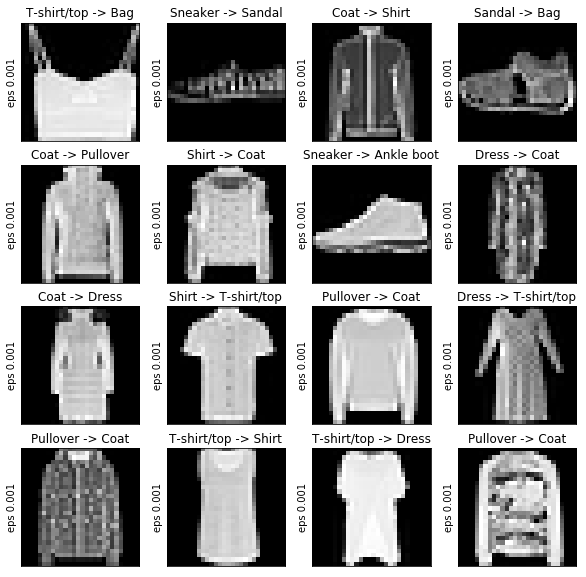

In [0]:
counter = 0
plt.rcParams["figure.figsize"] = [10, 10]

for i in range(50000):
    if min_epsilons[i] is not None and 0.0 < min_epsilons[i] <= 0.001:
        nabla = fgsa_get_nabla_sign(model3, x_train[i:i+1], y_train[i:i+1])
        img = x_train[i].squeeze(0) + min_epsilons[i] * nabla.to("cpu").squeeze(0).squeeze(0)
        with torch.no_grad():
            predicted = model3(img.unsqueeze(0).unsqueeze(0).to("cuda")).to("cpu").squeeze(0).argmax(0)
            print(predicted, y_train[i].squeeze(0))
        plt.subplot(4, 4, counter+1)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title("{} -> {}".format(classes[y_train[i].squeeze(0).item()], classes[predicted.item()]))
        plt.ylabel("eps {}".format(min_epsilons[i]))
        plt.imshow(img, cmap="gray")
        counter += 1
    if counter >= 16:
        break
plt.show()